<a href="https://colab.research.google.com/github/naza-campioni/fishery-models-tutorial/blob/main/VPA/vpa_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VPA - virtual population analysis model for stock assessment

needed:
1. catch in numbers C_{a,y} (data)
1. guess for natural mortality M
2. guess for terminal fishing mortality F_{A,Y}

from this we can estimate survivors, N_{A,Y}

then (by using Pope's approximation on fishing happening all at mid-year):

    N_{a,y} = N_{A,Y} e^M + C_{a,y}e^{M/2}



In [1]:
# clone repository
!git clone https://github.com/naza-campioni/fishery-models-tutorial.git

Cloning into 'fishery-models-tutorial'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 162 (delta 65), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (162/162), 274.51 KiB | 2.00 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [2]:
import sys
sys.path.append('/content/fishery-models-tutorial/VPA')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

In [4]:
# Go to repo directory (only if you've already cloned it)
%cd /content/fishery-models-tutorial
!git pull


/content/fishery-models-tutorial
Already up to date.


In [5]:
from vpa_model import (
    calculate_terminal,
    calculate_N,
    calculate_N_vectorized

)

In [6]:
a, y = 5, 7
C_ay = np.random.randint(low=500, high=1500, size=(a, y)) # catch-at-age matrix

M = 0.2 # natural mortality
F_AY = 0.3 # terminal fishing mortality

# calculate terminal population-at-age (survivors)
N_AY = calculate_terminal(M, F_AY, C_ay)

# calculate full population-at-age matrix using Pope's approximation
N_ay = calculate_N(M, C_ay, N_AY)

# calculate full population-at-age matrix in a vectorized manner
N_ay_vec = calculate_N_vectorized(M, C_ay, N_AY)

Text(0.5, 1.0, 'Cohort-based population dynamics')

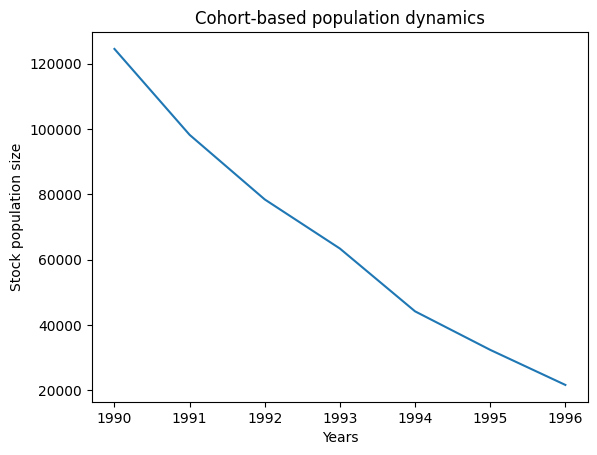

In [8]:
years = ['1990', '1991', '1992', '1993', '1994', '1995', '1996']

plt.plot(years,np.sum(N_ay, axis=0))

plt.xlabel('Years')
plt.ylabel('Stock population size')
plt.title('Cohort-based population dynamics')

Plot population dynamics calculated in a vectorized manner

Text(0.5, 1.0, 'Cohort-based population dynamics')

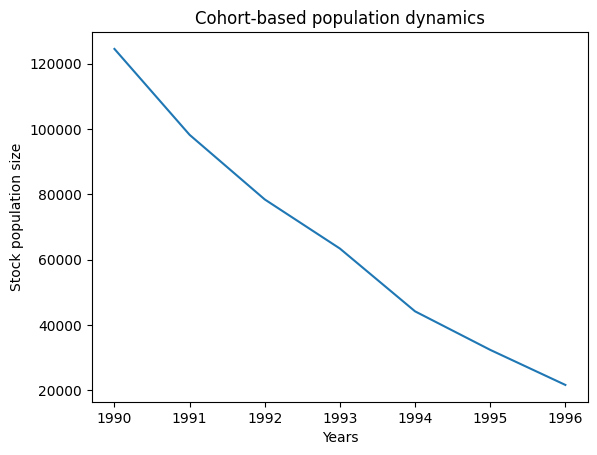

In [9]:
years = ['1990', '1991', '1992', '1993', '1994', '1995', '1996']

plt.plot(years,np.sum(N_ay_vec, axis=0))

plt.xlabel('Years')
plt.ylabel('Stock population size')
plt.title('Cohort-based population dynamics')

Next we can recover the fishing mortality rates F_{a,y}. How can we do that? We have two options:
1. use the exponential decay relation between next-year, next-age populations;
2. solve the Baranov's equation.

For the first solution, we can simply recover F_{a,y} as follows:

    N_{a+1,y+1} = N_{a,y}e^-(F_{a,y} + M)
    ie
    F_{a,y} = ln(N_{a,y}) - ln(N_{a+1,y+1}) - M
However, the underlying assumption is that the fishing mortality rate comes from the exponential relation between next-year and next-age populations, therefore it is not taking into consideration the information coming from the catches C_{a,y}. To leverage this information, we need to solve the Baranov's equation for F_{a,y}, which, being nonlinear, requires numerical approximation.